# Random Forest

In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit,learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
pickles_dir = 'results'

In [4]:
# Dataframe
path_df = pickles_dir+"/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = pickles_dir+"/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = pickles_dir+"/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = pickles_dir+"/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = pickles_dir+"/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [5]:
print(features_train.shape)
print(features_test.shape)

(1371, 1344)
(242, 1344)


## Cross-Validation for Hyperparameter tuning

In [6]:

rf_0 = RandomForestClassifier(random_state = 8)

print('Default parameters:\n')
pprint(rf_0.get_params())

Default parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


We'll tune the following ones:

n_estimators = number of trees in the forest.
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)


## Randomized Search Cross Validation

We first need to define the grid:

In [7]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [8]:
labels_train.dtype

dtype('int64')

In [9]:
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8,
                                   n_jobs = -1)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [10]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

The mean accuracy of a model with these hyperparameters is:
0.525164113785558


In [11]:
random_best_params = random_search.best_params_

## Grid Search Cross Validation

In [12]:
# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [80,100,120]
max_features = ['sqrt','auto']
min_samples_leaf = [1, 2]
min_samples_split = [1, 2]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1,
                           n_jobs = -1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\andrea.foroni\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.54451803        nan 0.54304636        nan 0.54451803
        nan 0.54304636        nan 0.53715968        nan 0.54378219
        nan 0.53715968        nan 0.54378219        nan 0.53715968
        nan 0.54378219        nan 0.53715968        nan 0.54378219]
  category=UserWarning


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=8), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [80, 100, 120],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2], 'n_estimators': [800]},
             scoring='accuracy', verbose=1)

In [13]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 80, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}

The mean accuracy of a model with these hyperparameters is:
0.5445180279617365


In [14]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=80, max_features='sqrt',
                       n_estimators=800, random_state=8)

## Model fit and performance¶

In [15]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, max_depth=80, max_features='sqrt',
                       n_estimators=800, random_state=8)

In [16]:
rfc_pred = best_rfc.predict(features_test)

### Training accuracy

In [17]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

The training accuracy is: 
0.9810357403355215


### Test accuracy

In [18]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.5082644628099173


### Classification report

In [19]:
# Classification report
print("Classification report")
print(classification_report(labels_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.30      0.46        20
           1       0.51      0.43      0.46        75
           2       0.00      0.00      0.00         1
           3       0.50      0.69      0.58        83
           4       0.44      0.46      0.45        50
           5       0.71      0.38      0.50        13

    accuracy                           0.51       242
   macro avg       0.53      0.38      0.41       242
weighted avg       0.54      0.51      0.50       242



C:\Users\andrea.foroni\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andrea.foroni\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andrea.foroni\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

### Confusion Matrix

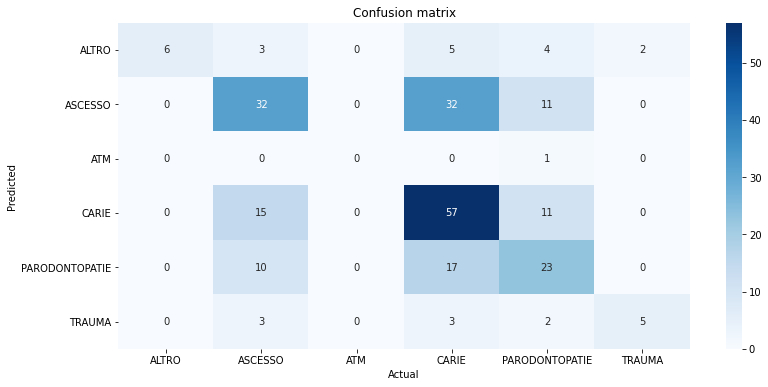

In [20]:
aux_df = df[['motivo_accesso', 'accesso_code']].drop_duplicates().sort_values('accesso_code')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=aux_df['motivo_accesso'].values, 
            yticklabels=aux_df['motivo_accesso'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [21]:
base_model = RandomForestClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.47520661157024796

In [22]:
best_rfc.fit(features_train, labels_train)
accuracy_score(labels_test, best_rfc.predict(features_test))

0.5082644628099173

In [23]:
d = {
     'Model': 'Random Forest',
     'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(d, index=[0])
df_models_rfc

,Model,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.981036,0.508264


In [24]:
with open(pickles_dir+'/best_rfc.pickle', 'wb') as output:
    pickle.dump(best_rfc, output)
    
with open(pickles_dir+'/df_models_rfc.pickle', 'wb') as output:
    pickle.dump(df_models_rfc, output)

In [25]:
train_sizes, train_scores, test_scores = learning_curve(best_rfc,
                                                       X=features_train,
                                                       y=labels_train
                                                       )

C:\Users\andrea.foroni\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


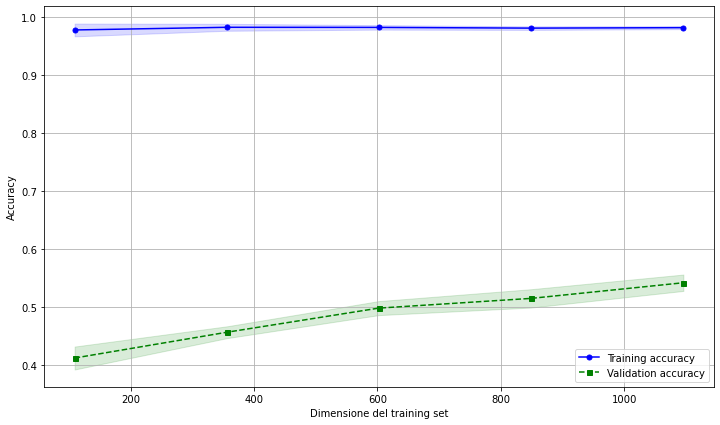

In [26]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Dimensione del training set')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')